In [13]:
import os
import pandas as pd

version = "PLIP" # PLIP or Scaffold

df = pd.DataFrame(columns=['cluster', 'filename', 'true_label', 'prediction'])
sdf_dir = "../Data/other/SDF poses"
json_base_dir = f"../Results/pharmacophores/{version}_based"

clusters = [d for d in os.listdir(json_base_dir) if d.startswith('cluster_')]

for cluster in clusters:
    json_dir = os.path.join(json_base_dir, cluster)
    json_files = {f[:-5] for f in os.listdir(json_dir) if f.endswith('.json')}
    
    filenames = [f[:-4] for f in os.listdir(sdf_dir) if f.endswith('.sdf')]
    
    temp_df = pd.DataFrame({
        'cluster': cluster,
        'filename': filenames,
        'true_label': [1 if f in json_files else 0 for f in filenames],
        'prediction': 0
    })
    
    df = pd.concat([df, temp_df], ignore_index=True)

df

,cluster,filename,true_label,prediction
0,cluster_6,B4B_5OXG,0,0
1,cluster_6,UIAR_VINA,0,0
2,cluster_6,C9U_6JUX,0,0
3,cluster_6,H8H_6ZGC,0,0
4,cluster_6,XQX_8UWR,0,0
...,...,...,...,...
317,cluster_3,A1A3C_9D8F,0,0
318,cluster_3,MM8_6T6D,0,0
319,cluster_3,IYZ_4DYM,0,0
320,cluster_3,TAK_3H9R,1,0


In [14]:
#merge
df2 = pd.read_csv(f'../Results/pharmacophores/{version}_based/{version}_results/merged_output.csv')

df['prediction'] = df.apply(
    lambda row: 1 if ((df2['cluster'] == row['cluster']) & (df2['filename'] == row['filename'])).any() else 0,
    axis=1
)


In [15]:
print(df.groupby('cluster')[['true_label', 'prediction']].sum())

          true_label  prediction
cluster                         
cluster_1          4           9
cluster_2          3           7
cluster_3          9           6
cluster_4          3           3
cluster_5          5          18
cluster_6          4          19
cluster_7          3           4


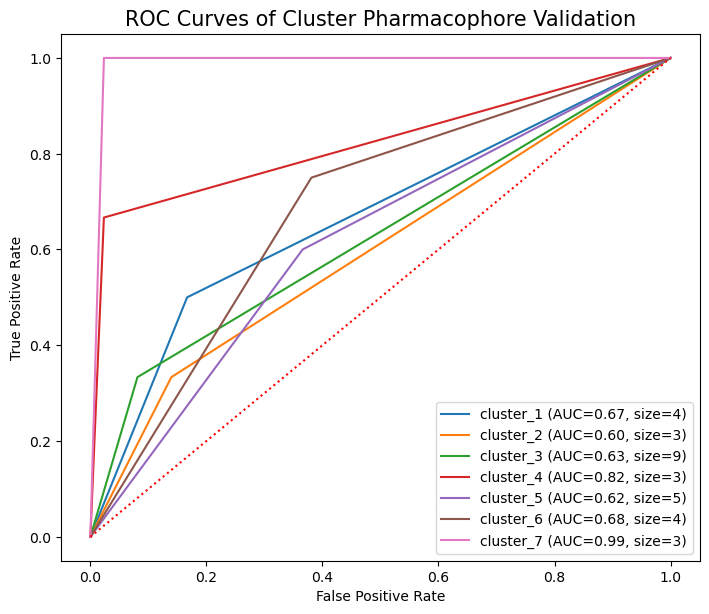

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))

for cluster, group in df.groupby('cluster'):
    true_labels = group['true_label'].astype(int)
    predicted_fit = group['prediction'].astype(int)
    size = true_labels.sum()
    
    if true_labels.nunique() < 2 or predicted_fit.nunique() < 2:
        continue

    fpr, tpr, _ = roc_curve(true_labels, predicted_fit)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{cluster} (AUC={roc_auc:.2f}, size={size})")


plt.plot([0, 1], [0, 1], linestyle='dotted', color='red')
plt.xlabel("False Positive Rate", fontsize=10)
plt.tight_layout()
plt.ylabel("True Positive Rate", fontsize=10)
plt.title("ROC Curves of Cluster Pharmacophore Validation", fontsize=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid(False)
plt.show()


<Figure size 400x400 with 0 Axes>

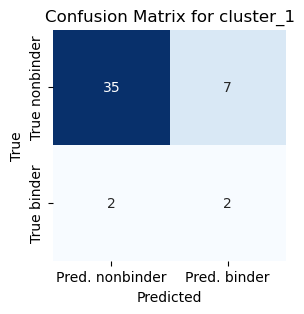

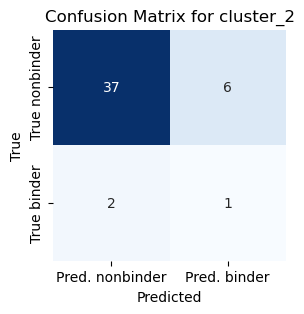

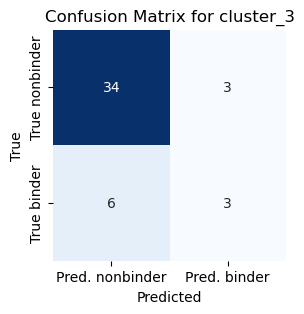

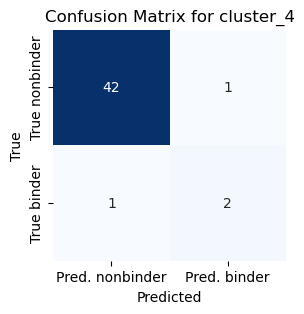

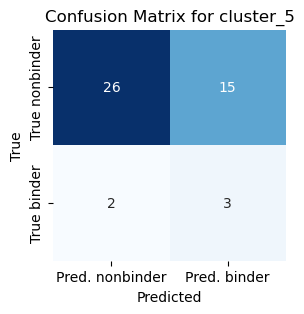

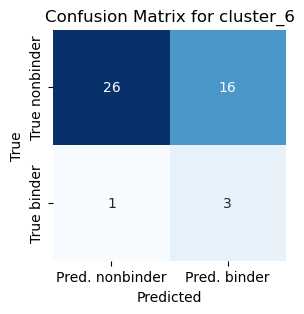

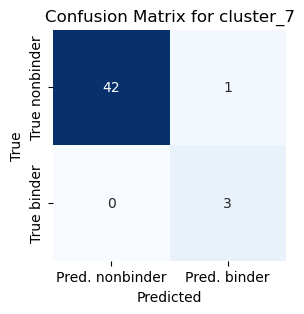

In [17]:
# plot confusion matrix for each cluster
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(4, 4))
for cluster, group in df.groupby('cluster'):
    true_labels = group['true_label'].astype(int)
    predicted_fit = group['prediction'].astype(int)
    
    if true_labels.nunique() < 2 or predicted_fit.nunique() < 2:
        continue

    cm = confusion_matrix(true_labels, predicted_fit)
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred. nonbinder', 'Pred. binder'],
                yticklabels=['True nonbinder', 'True binder'])
    
    plt.title(f'Confusion Matrix for {cluster}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()